# DSCI 552 Lecture: Maximum Likelihood Estimation

## Today's Learning Goals

By the end of this lecture, you should be able to:

1. Explain the concept of maximum likelihood estimation (MLE).
2. Apply MLE for cases with one population parameter.

## Loading `R` Packages

Let us load the libraries for data wrangling, analysis, and plotting.

In [1]:
options(repr.plot.height = 8, repr.plot.width = 20)
options(repr.matrix.max.rows = 6)
source("scripts/support_functions.R")
library(tidyverse)
library(gridExtra)

── Attaching packages ─────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.0 
✔ readr   2.1.2      ✔ forcats 0.5.1 
── Conflicts ────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## 1. Estimating population parameters in a different way!

Let us go one step further on population parameter estimation. So far, we have dealt with single parameters in our confidence intervals and hypothesis testings.

Nonetheless, **what happens if we want to estimate more than just a single parameter?** There are many different statistical distributions (**including the normal!**) with more than one parameter.

We can use MLE for **univariate** or **multivariate** purposes. This method heavily relies on **a random sample of $n$ observations** coming from the **population of interest**.

### 1.1. A first example!

Suppose we have an **empirical distribution** of standard deviations of gene expression for different genes. This empirical distribution corresponds to a random sample of standard deviations.

Moreover, we would like to estimate the parameters from the population this sample is coming from.

```{figure} img/mle_motivation.png
:height: 750px
:name: mle_motivation

Image from *Data Analysis for the Life Sciences* (Irizarry and Love, 2016).
```

### 1.2. How can we do this?

This illustration gives us some ideas. First, note the same histogram corresponding to the random sample appears in each cell of the grid. Second, the red line represents a given theoretical probability density function (PDF) under specific population parameters.

Now, we might wonder: **what red line fits the histogram better?**


```{attention}
The question above is the intuition of MLE!
```

## 2. What is the definition of MLE?

MLE is a method that, given some observed data and some assumed family of probability distributions, seeks to find values of the parameters that would make the observed data **most likely to have occurred**.

```{admonition} Alternatively:
MLE is a method that, given some observed data and some assumed family of probability distributions, seeks to find the distribution that would make the observed data most likely to have occurred. The parameters specify this distribution.
```

These are the **EMPIRICAL** steps we follow for our previous example using MLE:

1. Firstly, we choose a family of theoretical distributions that we believe our observed sample distribution comes from. Here, we chose an [$F$-distribution](https://en.wikipedia.org/wiki/F-distribution). 

```{important}
How we choose the family of distributions for our statistical modelling will be covered in more detail in **DSCI 562**.
```

2. Next, we vary the parameter(s) for that **parametric family of theoretical distributions** to find a specific, single distribution that best fits the observed data. 

```{important}
The $F$-distribution has two parameters ($d$ which controls the location and $s_0$ which controls the scale). We started our discussion of MLE by just varying one of these parameters, $s_0$, while holding $d$ fixed at 10.
```

From the histograms above, can we do it just "by eye"? Not precisely. So how can we do this? MLE is one way. Let us now explore how.

### 2.1. Some key ideas...

- We aim to estimate the parameters of a theoretical distribution (e.g., $\mu$ and/or $\sigma^2$ in the case of a Normal distribution). 
- Therefore, we need to make a distributional assumption for our data - at the family level (choose a distribution: Normal, Exponential, Poisson, Binomial, etc.).

```{important}
One crucial element to consider is the nature of our variable of interest (is it continuous or discrete?).
```

- Then, we play around with the parameters for that family of distributions to find the one that would be **most likely** given our data, and we choose the corresponding parametric **estimates**.
- To obtain these estimates, we use the **likelihood function**.

### 2.2. But, what is the likelihood function?

Let us set another example. Suppose we draw a random sample of $n = 30$ observations from a **continuous population**.

In [2]:
sample_n30 <- tibble(values = c(
  24.9458614574341, 7.23174970992907, 4.16136401519179, 5.60304128237143,
  5.37929488345981, 1.40547217217847, 7.0701988485075, 2.84055356831115,
  0.894746121019125, 2.9016381111011, 3.19011222943664, 11.0930137682099,
  3.49700326472521, 46.2914818498428, 2.00653892990149, 2.87363994969391,
  11.4050390862658, 11.6616687767937, 12.8855835341646, 3.88483320176601,
  0.406148910522461, 25.7642258988289, 8.4743227359272, 4.17410666868091,
  1.84968510270119, 2.15972620035141, 10.5289600339151, 6.44162824716339,
  10.6035323139645, 66.6861112673485
))

Let us plot the empirical (sample) distribution as a histogram but using a density scale, as a first step:

In [3]:
hist_sample_n30 <- sample_n30 %>%
    ggplot() +
    geom_histogram(aes(values, ..density..), fill = "grey", color = "black", bins = 50) +
    theme(
      plot.title = element_text(size = 24, face = "bold"),
      axis.text = element_text(size = 18),
      axis.title = element_text(size = 24)
    ) +
    ggtitle("Histogram of a Continuous Random Sample of n = 30") +
    scale_colour_discrete(name = expression(paste("Rate (", lambda, ")"))) +
    labs(x = "Observed Value", y = "Density")

Note `y = ..density..` transforms the $y$-values on the histogram from counts to a density.

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


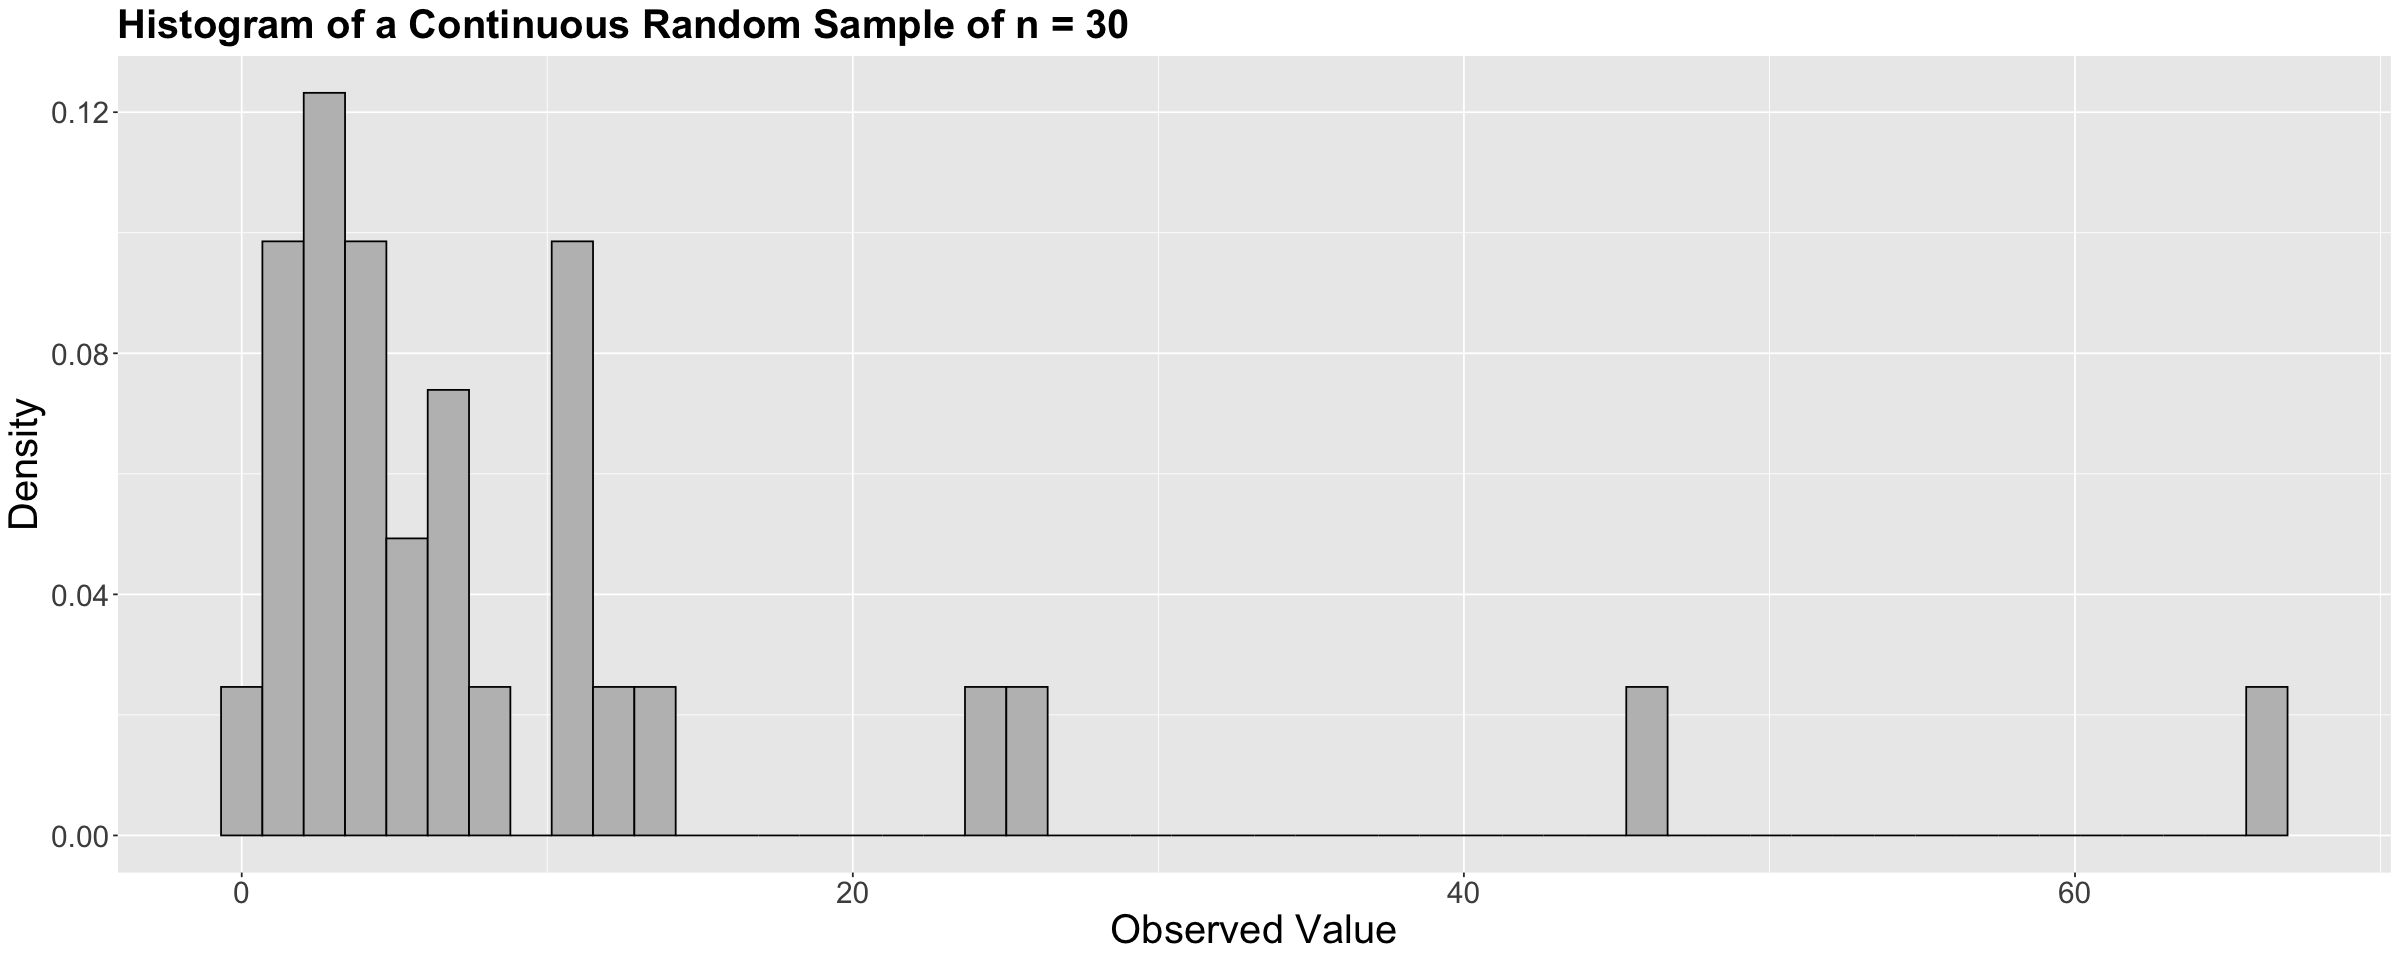

In [4]:
hist_sample_n30

We will assume it is an **Exponential population** whose unknown parameter is $\lambda$ (**note we have nonnegative continuous observations!**). Therefore, **we aim to estimate $\lambda$ via the observed values in this random sample.** Moreover, given our distributional assumption, each observation is $y_i$ ($i = 1, \dots, 30$) with the following PDF:

$$
f_{Y_i}(y_i \mid \lambda) = \lambda \exp(-\lambda y_i).
$$

How can we obtain an estimate for $\lambda$? MLE is one possible approach to overcome this matter:

- First, we choose a theoretical distribution that we believe our sample's empirical distribution is coming. The equation above, $f_{Y_i}(y_i \mid \lambda)$, will be extremely useful. Here we chose a distribution such as the Exponential given our right-skewed `hist_sample_n30` (the empirical distribution).
- Since it is a random sample, we assume all the $n$ observations are *iid*. This assumption leads to the following **joint PDF**:

$$
f_{Y_1, \dots, Y_n}(y_1, \dots, y_n \mid \lambda) = \prod_{i = 1}^n \lambda \exp(-\lambda y_i).
$$

Now, you might wonder: *where is the likelihood function?* The likelihood function is a function of the parameters of a given/chosen theoretical distribution.

It is equivalent (**mathematically!**) to the joint PDF (or probability mass function, PMF, if the random variables are discrete as we will see in `lab4`). **However, we have to change our perspective: we do not know the population parameter, but the sample's observed values**.

From our previous example with the joint PDF $f_{Y_1, \dots, Y_n}(y_1, \dots, y_n \mid \lambda)$, this implicates:

$$\mathscr{l}(\lambda \mid y_1, \dots, y_n) = f_{Y_1, \dots, Y_n}(y_1, \dots, y_n \mid \lambda) = \prod_{i = 1}^n \lambda \exp(-\lambda y_i).$$

### 2.3. (Digression) How do we compute the likelihood?

**A smaller and different sample of $n = 3$**

Let us suppose that we only have three observations (note the lowercases!): $y_1 = 0.8$, $y_2 = 2.1$, and $y_3 = 2.4$. Moreover, we will assume they come from **the family of Exponential distributions**. The likelihood function would be the joint PDF of this sample:

$$\mathscr{l}(\lambda \mid y_1, y_2, y_3) = \lambda \exp(-\lambda y_1) \times \lambda \exp(-\lambda y_2) \times \lambda \exp(-\lambda y_3)$$

$$\mathscr{l}(\lambda \mid y_1, y_2, y_3) = \lambda \exp[-\lambda (0.8)] \times \lambda \exp[-\lambda (2.1)] \times \lambda \exp[-\lambda (2.4)].$$

Look at the left-hand side of the likelihood equation! **The likelihood function is NOT a PDF**, even though it mathematically looks the same as the joint PDF of your sample. **The likelihood function is a function of the parameter $\lambda$ and not $y_1$, $y_2$, and $y_3$.**

**Calculating the likelihood value**

Since we want to calculate the likelihood of a specific theoretical distribution given the data we have observed:

$$\mathscr{l}(\text{distributional parameter}\, | \,\text{observed data});$$

to calculate the likelihood for a specific distribution for that family, we choose a specific value for $\lambda$. Then, we calculate the likelihood. For instance, what is the likelihood of an exponential distribution where $\lambda = 2$ given the data we observed?

$$\mathscr{l}(\lambda = 2 \mid y_1, y_2, y_3) = 2 \exp[-2 (0.8)] \times 2 \exp[2 (2.1)] \times 2 \exp[2 (2.4)].$$

Let us use `R`!

In [5]:
(2 * exp(-2 * 0.8)) * (2 * exp(-2 * 2.1)) * (2 * exp(-2 * 2.4))

[1] 0.0001993281

Or more easily (via `dexp()`):

In [6]:
data <- c(0.8, 2.1, 2.4)
prod(dexp(data, 2))

[1] 0.0001993281

We can use another two $\lambda$ values to compute the corresponding likelihood given the data we observed. Let us use $\lambda = 0.5$ and $0.05$.

In [7]:
prod(dexp(data, 0.5))
prod(dexp(data, 0.05))

[1] 0.008831402

[1] 9.590074e-05

**Removing the curtain!**

The observed data was actually drawn from an exponential distribution with $\lambda = 0.5$. Thus, it is not a surprise that the likelihood is higher for this value of $\lambda$ than the other two we tried.

### 2.4. Going back to our `sample_n30` 

In [8]:
sample_n30

values
<dbl>
24.945861
7.231750
4.161364
⋮
6.441628
10.603532
66.686111


We will choose a few different exponential distributions (by varying $\lambda$), calculate the likelihood for those distributions given the data we observed, and then overlay those distributions on the empirical distributions (i.e., histograms) to see how they map together.

Let us try the following $\lambda$ values: $0.05$, $0.125$ and $0.5$.

We will calculate the **theoretical `density`** of an Exponential distribution with $\lambda = 0.05$ for a **sequence of quantiles** (`x`) from `0` to `70` by `0.05`:

In [9]:
likelihood_0.05 <- prod(dexp(sample_n30$values, 0.05))
likelihood_0.05

density_0.05 <- tibble(
  x = seq(0, 70, 0.05),
  density = dexp(x, 0.05)
)
density_0.05

[1] 1.880207e-46

x,density
<dbl>,<dbl>
0.00,0.05000000
0.05,0.04987516
0.10,0.04975062
⋮,⋮
69.90,0.001517437
69.95,0.001513649
70.00,0.001509869


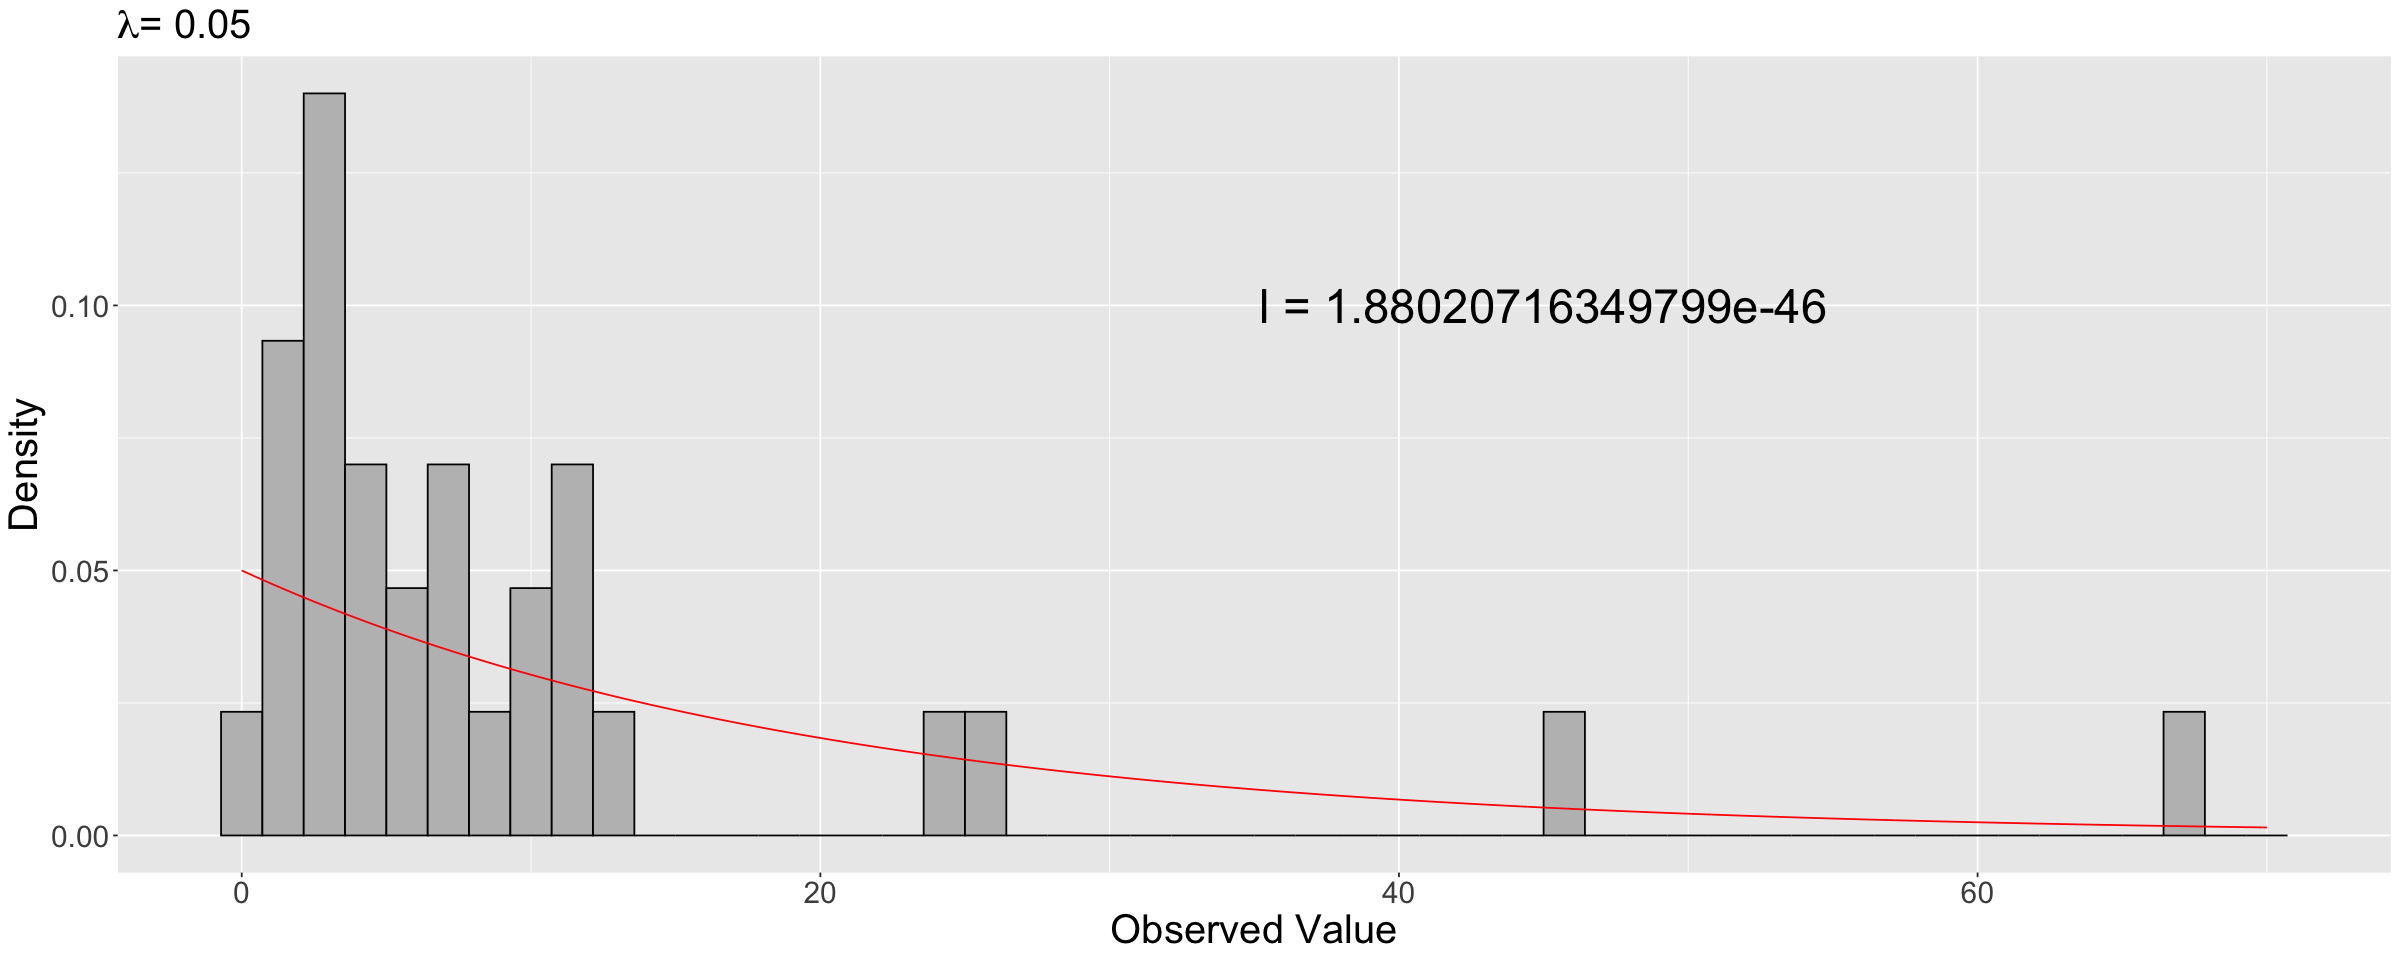

In [10]:
plot_lambda_0.05 <- hist_sample_n30 +
  geom_line(
    data = density_0.05,
    aes(x = x, y = density), colour = "red"
  ) +
  annotate("text", x = 45, y = 0.1, label = paste0("l = ", likelihood_0.05), size = 10) +
  ggtitle(expression(paste(lambda, "= 0.05")))

plot_lambda_0.05

Now for $\lambda$ values of $0.125$ and $0.5$:

In [11]:
likelihood_0.125 <- prod(dexp(sample_n30$values, 0.125))
likelihood_0.125

density_0.125 <- tibble(
  x = seq(0, 70, 0.125),
  density = dexp(x, 0.125)
)

[1] 1.479327e-44

In [12]:
likelihood_0.5 <- prod(dexp(sample_n30$values, 0.5))
likelihood_0.5

density_0.5 <- tibble(
  x = seq(0, 70, 0.5),
  density = dexp(x, 0.5)
)

[1] 1.047504e-76

In [13]:
plot_lambda_0.125 <- hist_sample_n30 +
  geom_line(
    data = density_0.125,
    aes(x = x, y = density), colour = "red"
  ) +
  annotate("text", x = 45, y = 0.1, label = paste0("l = ", likelihood_0.125), size = 10) +
  ggtitle(expression(paste(lambda, "= 0.125"))) + ylim(c(0, 0.5))

plot_lambda_0.5 <- hist_sample_n30 +
  geom_line(
    data = density_0.5,
    aes(x = x, y = density), colour = "red"
  ) +
  annotate("text", x = 45, y = 0.1, label = paste0("l = ", likelihood_0.5), size = 10) +
  ggtitle(expression(paste(lambda, "= 0.5")))

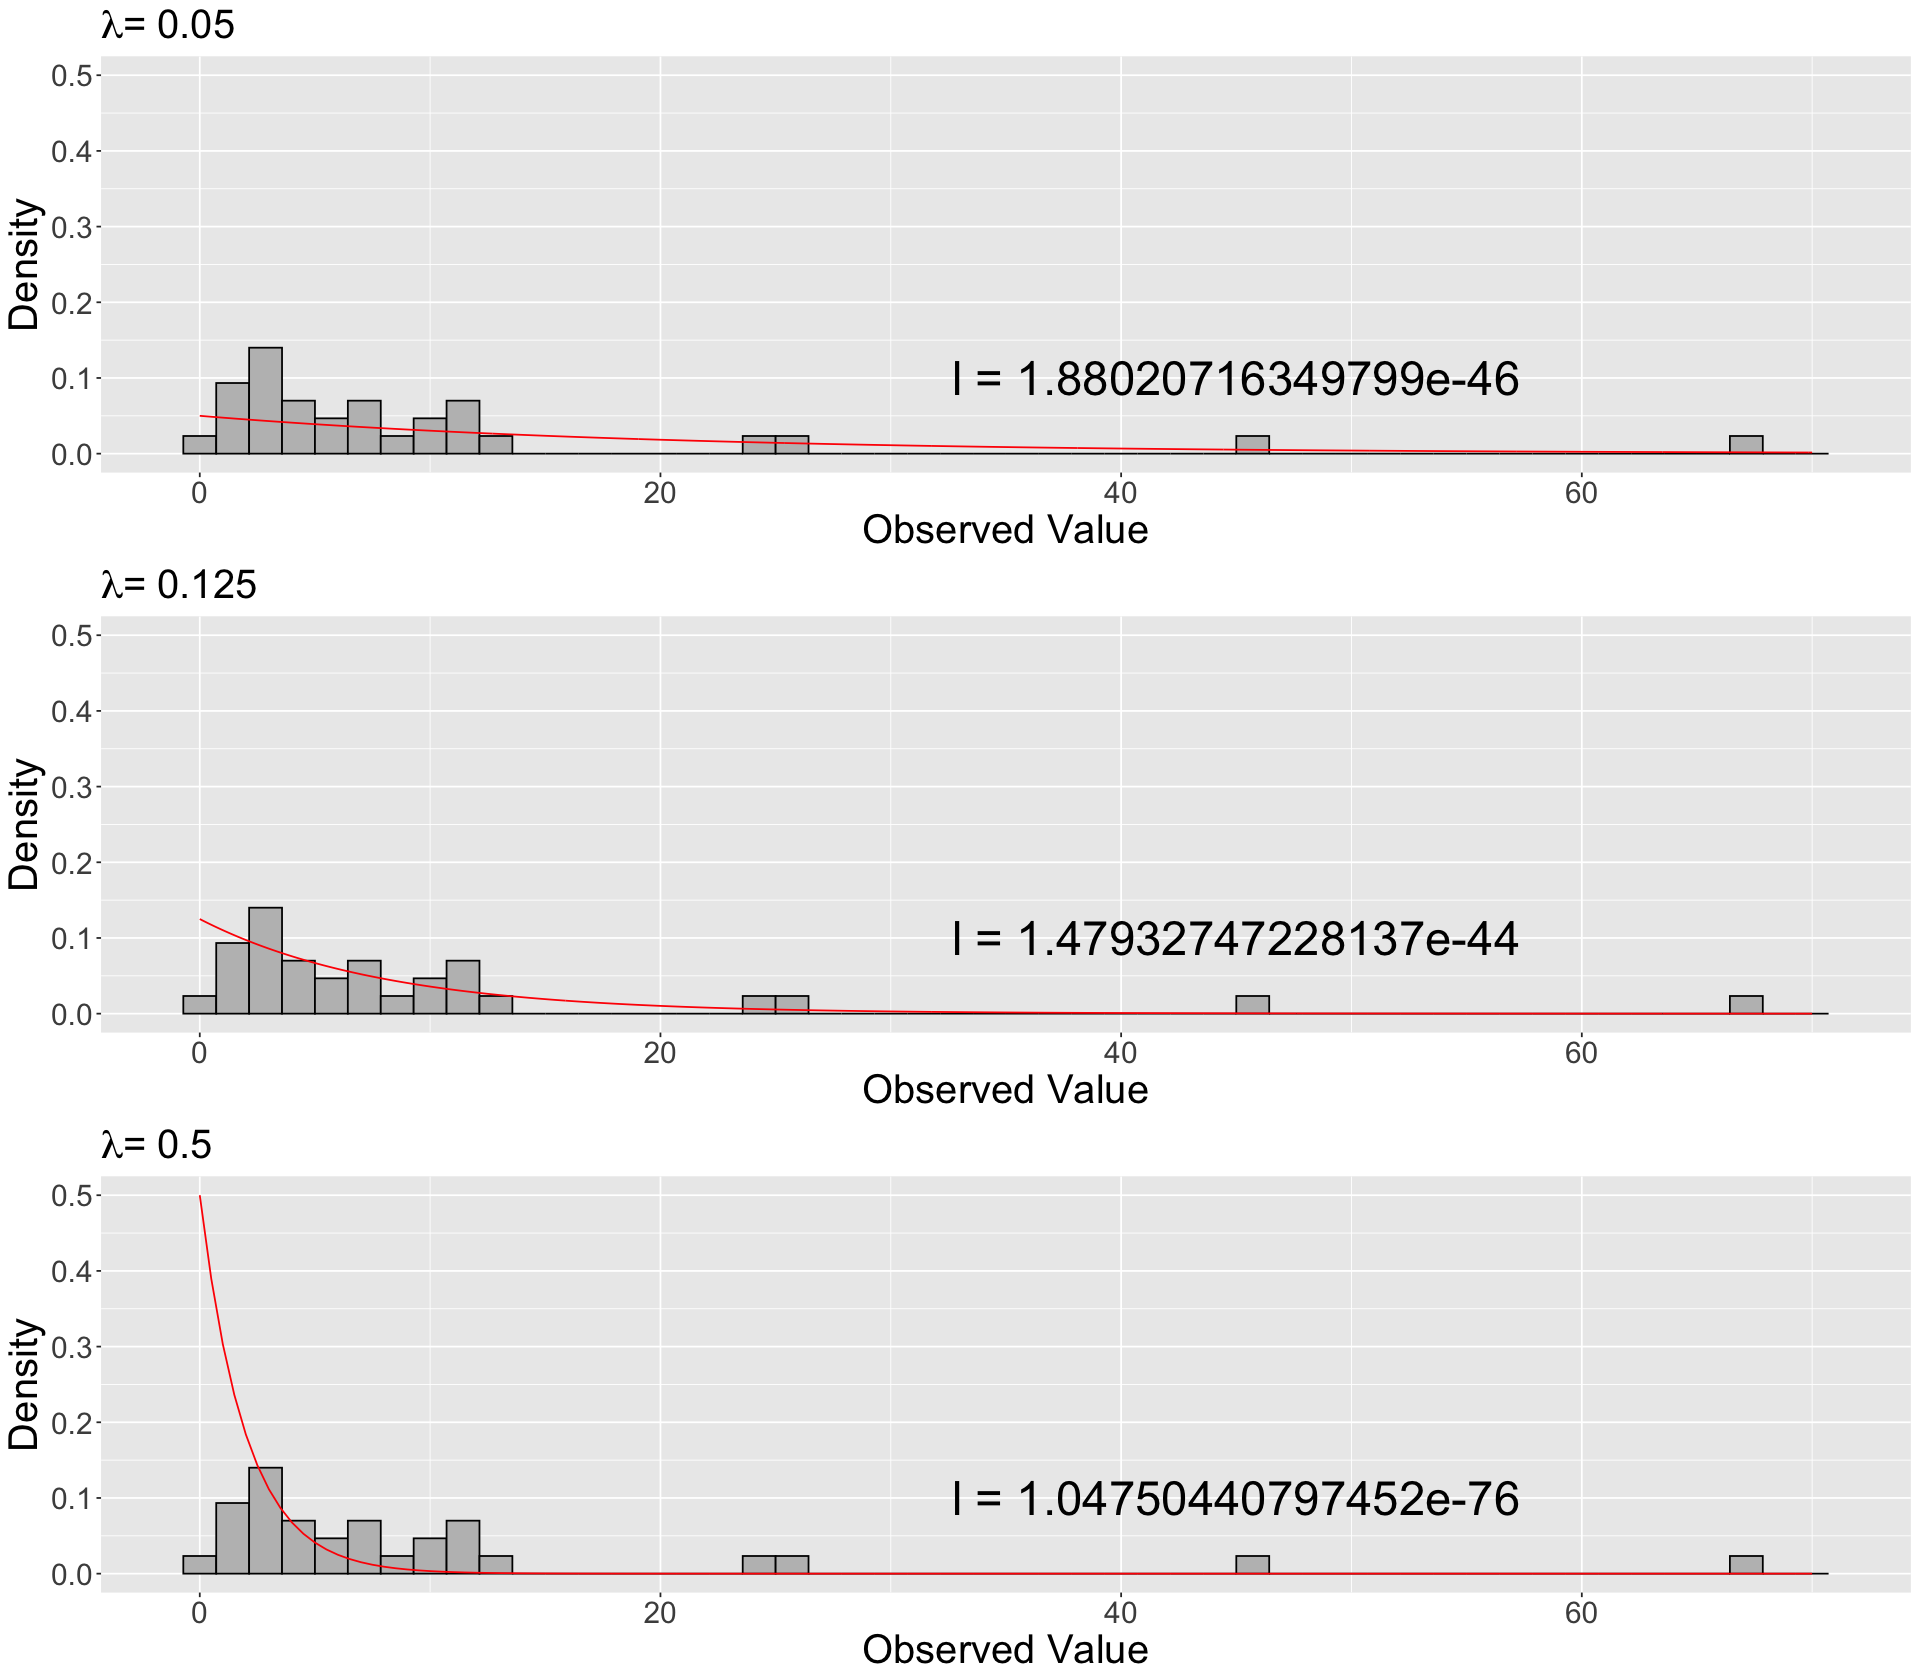

In [14]:
options(repr.plot.width = 16, repr.plot.height = 14)
grid.arrange(plot_lambda_0.05 + ylim(c(0, 0.5)), plot_lambda_0.125, plot_lambda_0.5, nrow = 3)

**We can see that the LARGEST likelihood value maps onto the Exponential distribution that best fits the observed data: the one with $\lambda = 0.125$ (note the $y$-axis scale is the same for the three histograms)**. However, to find the maximum likelihood value (and hence best $\lambda$ to specify our specific Exponential distribution) using this approach would take forever and/or be impossible.

Let us instead calculate and visualize the likelihoods for a wide range of $\lambda$'s and choose the specific distribution with the maximum likelihood.

```{attention}
Even though we will automatically try a wide range of $\lambda$ values to obtain the one that yields the maximum likelihood, **this is not an analytical solution but empirical**.
```

### 2.5. Interlude: The wonders of log-likelihood

Let us re-check the three previous likelihood values coming from `sample_n30`:

In [15]:
likelihood_0.05
likelihood_0.125
likelihood_0.5

[1] 1.880207e-46

[1] 1.479327e-44

[1] 1.047504e-76

Likelihood values are super small! Hence, we could make a logarithmic transformation (i.e., a monotonic transformation) on the base $e$ for the likelihood function: **the log-likelihood function**.

In [16]:
round(log(likelihood_0.05), 4)
round(log(likelihood_0.125), 4)
round(log(likelihood_0.5), 4)

[1] -105.2875

[1] -100.9222

[1] -174.9501

The use of the log-likelihood function is common in MLE. 

As previously stated, we would not know the real value for $\lambda$. The empirical use above, to estimate the value for $\lambda$, shows us that $\lambda = 0.125$ provides the *maximum* value (i.e., the less negative value) for the log-likelihood function **from these three possible options**. This $\lambda = 0.125$ is the value under which our random sample is more likely (under the assumption of an Exponential distribution).

### 2.6. Finding the maximum likelihood and log-likelihood using a range of $\lambda$ values

Let us calculate the likelihood and log-likelihood values for a range of $\lambda$ for our `hist_sample_n30` and then plot these.

What range? We will talk more about deciding this in a bit, but for now, we will try $0.01$ to $0.2$.

In [17]:
exp_values <- tibble(
  possible_lambdas = seq(0.01, 0.2, 0.001),
  likelihood = map_dbl(possible_lambdas, ~ prod(dexp(sample_n30$values, .))),
  log_likelihood = map_dbl(possible_lambdas, ~ log(prod(dexp(sample_n30$values, .))))
)
exp_values

possible_lambdas,likelihood,log_likelihood
<dbl>,<dbl>,<dbl>
0.010,4.581642e-62,-141.2382
0.011,5.873592e-61,-138.6872
0.012,5.870333e-60,-136.3852
⋮,⋮,⋮
0.198,2.444408e-48,-109.6303
0.199,2.088875e-48,-109.7875
0.200,1.783701e-48,-109.9454


Plot the possible $\lambda$'s against the likelihood of observing them given our data:

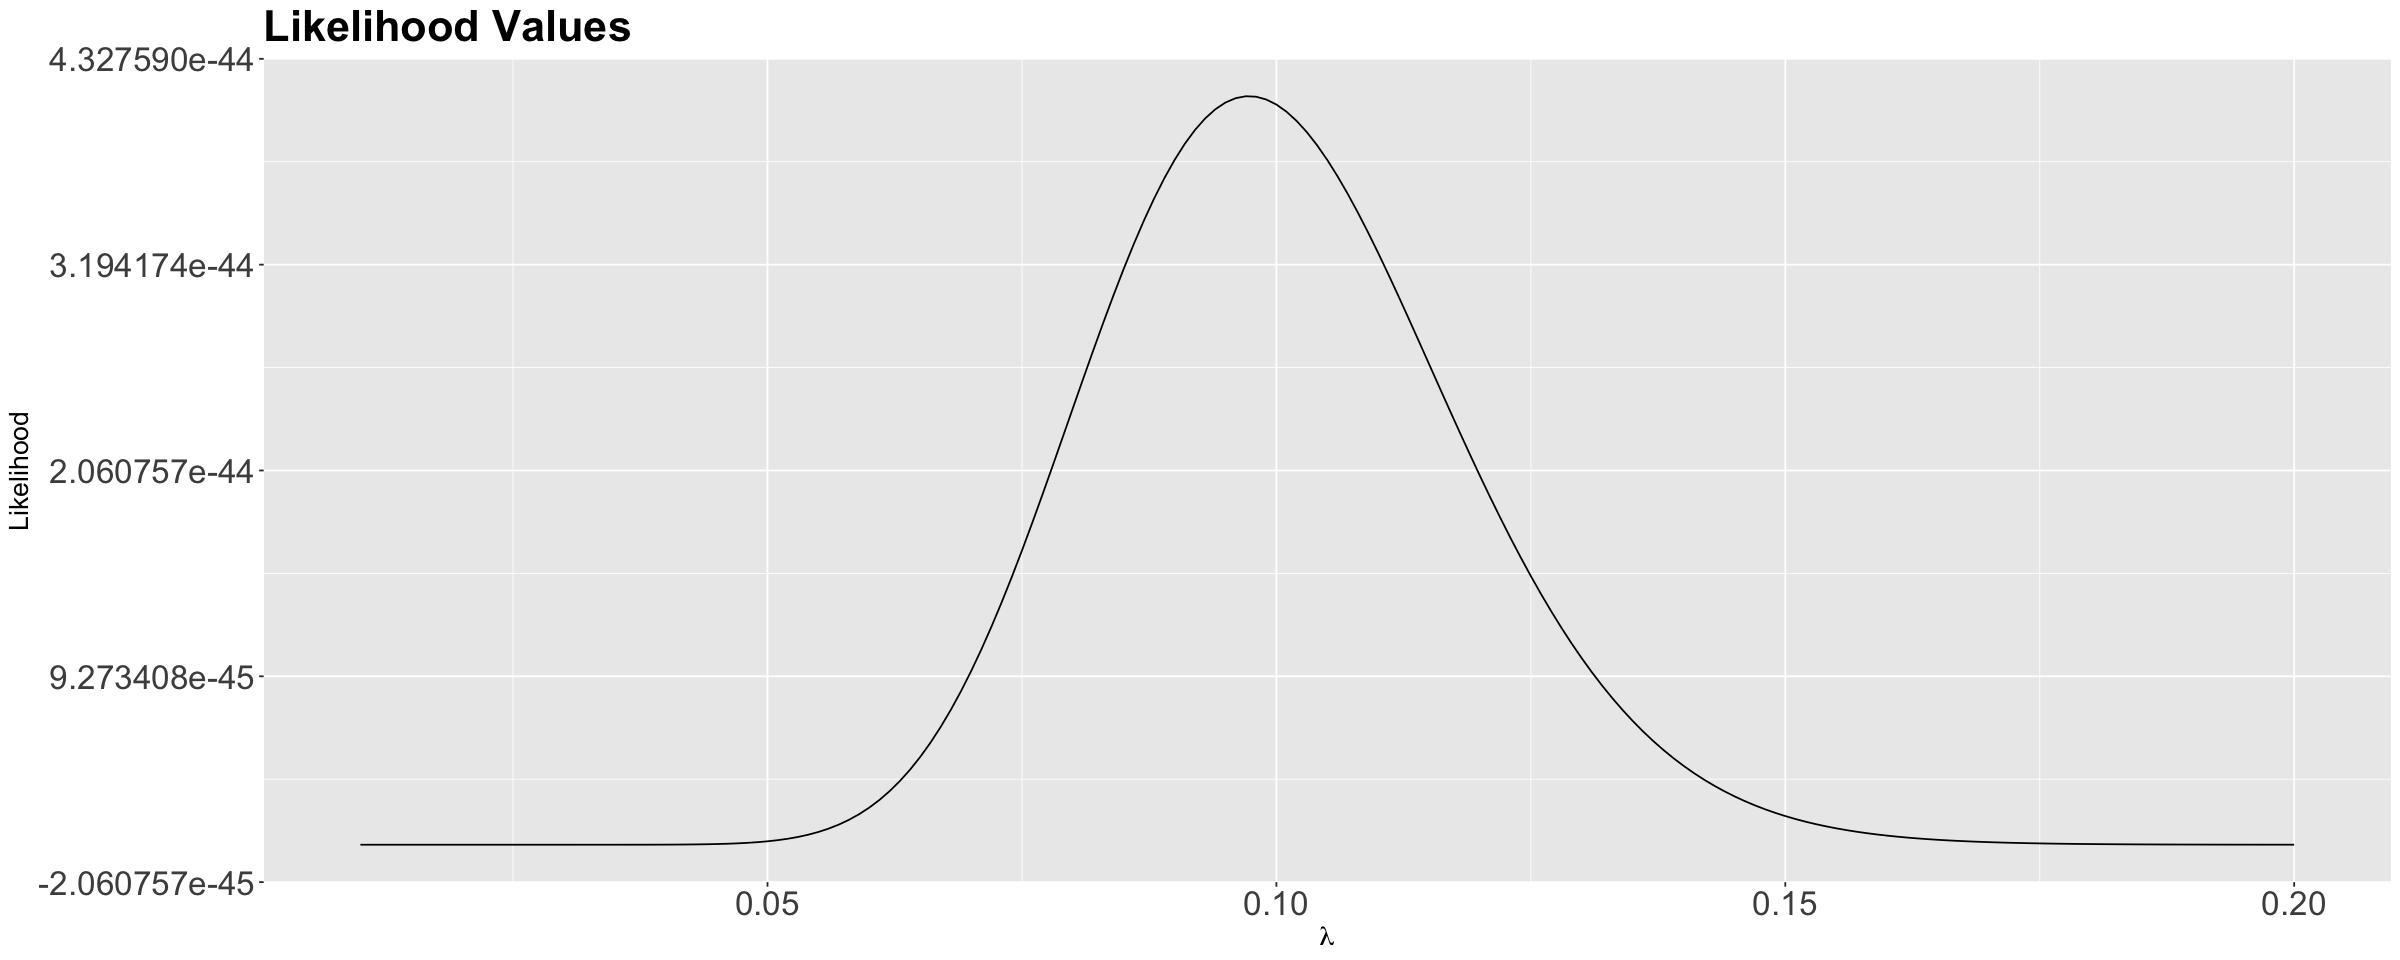

In [18]:
options(repr.plot.height = 8, repr.plot.width = 20)

(exp_like_plot <- ggplot(exp_values, aes(x = possible_lambdas, y = likelihood)) +
  geom_line() +
  theme(
    plot.title = element_text(size = 26, face = "bold"),
    axis.text = element_text(size = 20),
    axis.title = element_text(size = 16)
  ) +
  ggtitle("Likelihood Values") +
  labs(x = expression(lambda), y = "Likelihood"))

How about the log-likelihood values?

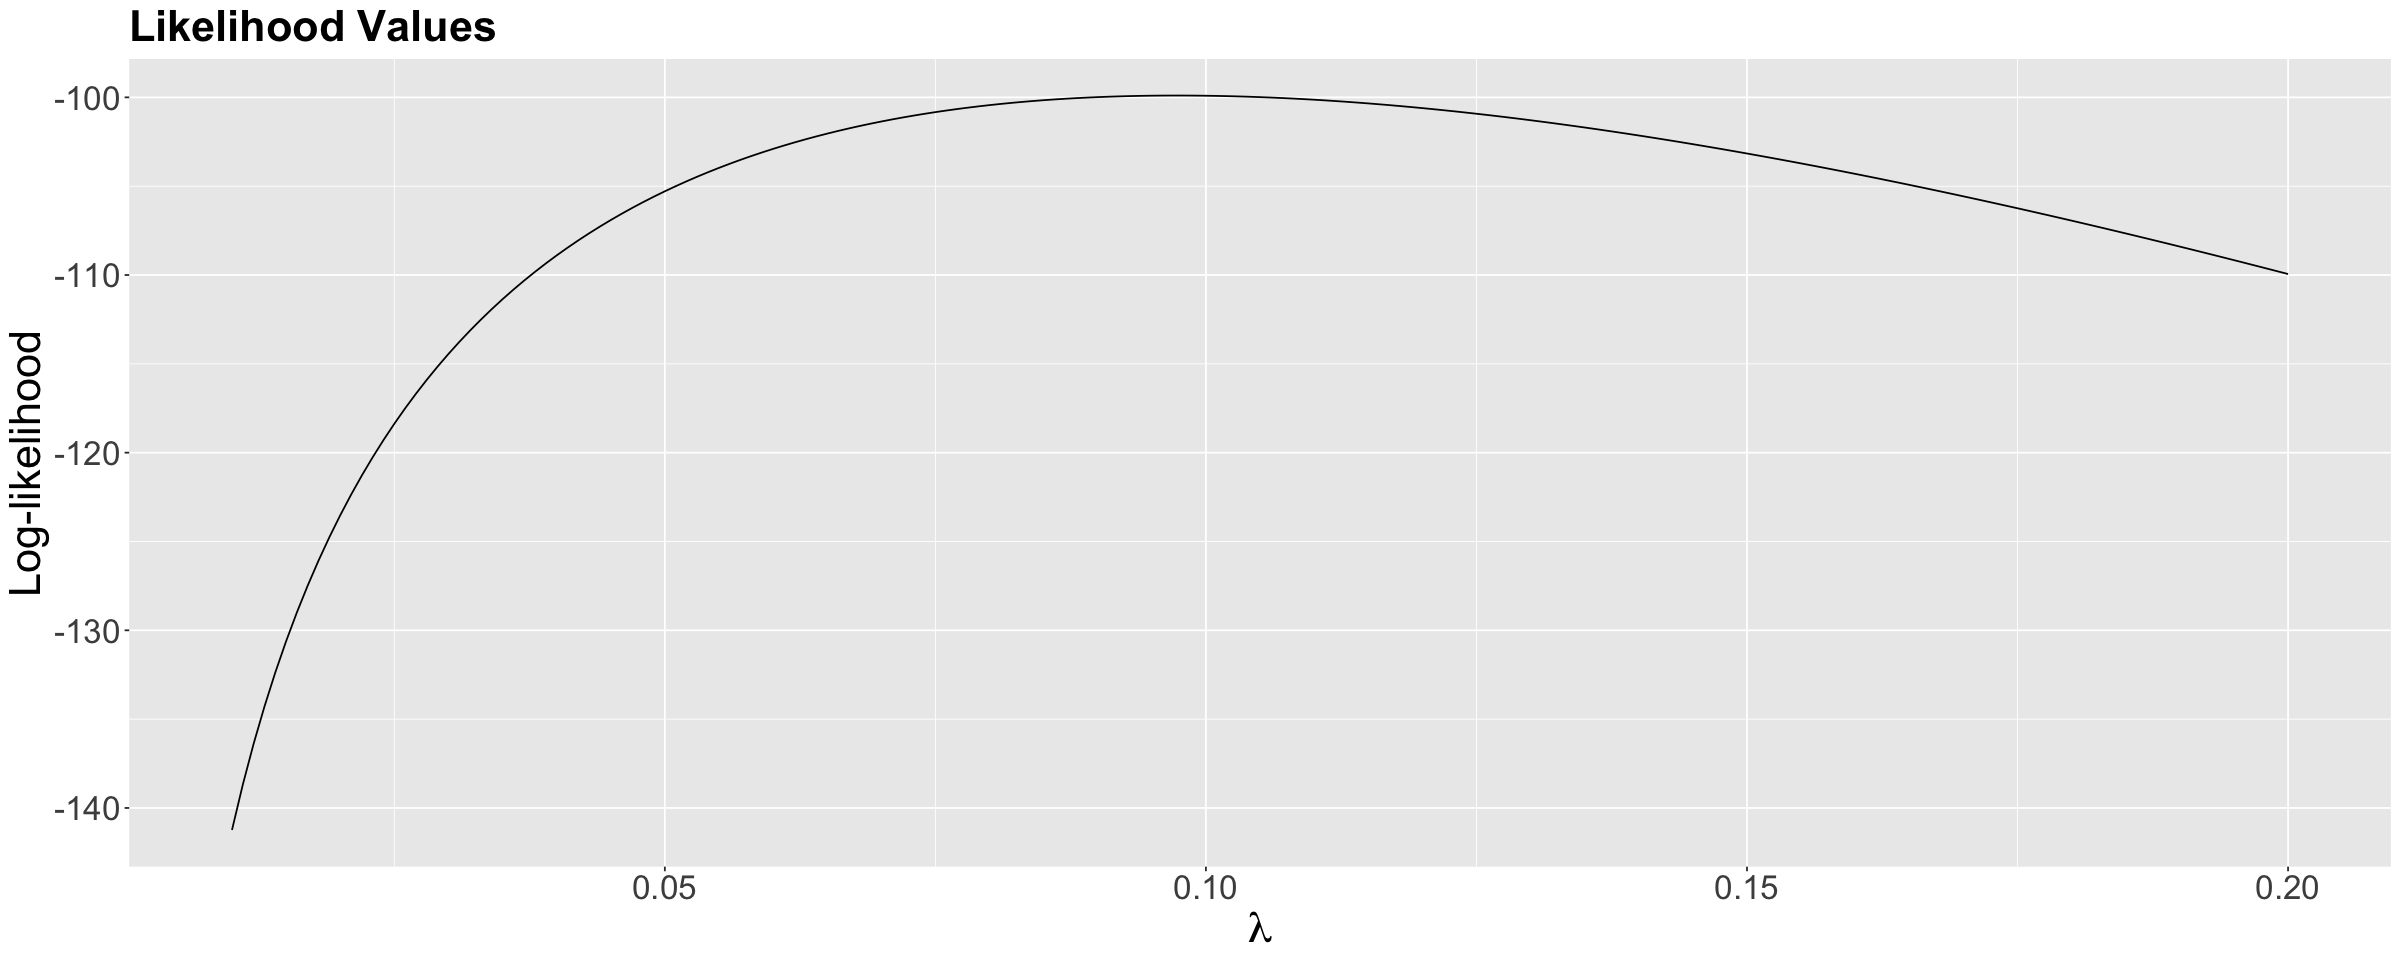

In [19]:
(exp_log_like_plot <- ggplot(exp_values, aes(x = possible_lambdas, y = log_likelihood)) +
  geom_line() +
  theme(
    plot.title = element_text(size = 26, face = "bold"),
    axis.text = element_text(size = 20),
    axis.title = element_text(size = 26)
  ) +
  ggtitle("Likelihood Values") +
  labs(x = expression(lambda), y = "Log-likelihood"))

What is the maximum? Reading off the graph is a bit difficult, so we will grab the maximum:

In [20]:
empirical_MLE <- exp_values %>%
  arrange(desc(likelihood)) %>%
  slice(1)
empirical_MLE

possible_lambdas,likelihood,log_likelihood
<dbl>,<dbl>,<dbl>
0.097,4.121515e-44,-99.89752


```{attention}
The precision of the maximum likelihood estimate we can come up with, **using this empirical method**, depends on the increments by which we vary $\lambda$.
```

## 3. Can we apply MLE analytically?

**Yes, we can!**

And it will involve multivariate calculus since we have an optimization problem.

**Let us do it with $\lambda$ in the exponential distribution!**

1. We will generalize our derivation by assuming a random sample of $n$ observations (they are independent and identically distributed). Recall that the $i$th observation ($i = 1, \dots, n$) has the following PDF:

$$
f_{Y_i}(y_i \mid \lambda) = \lambda \exp(-\lambda y_i).
$$

2. Since the $n$ observations are assumed independent, the joint PDF is as folllows:

$$
f_{Y_1, \dots, Y_n}(y_1, \dots, y_n \mid \lambda) = \prod_{i = 1}^n \lambda \exp(-\lambda y_i).
$$

3. The joint likelihood function is mathematically equivalent to the joint PDF. Thus, along with some algebraic rearrangements, we have:

$$
\mathscr{l}(\lambda \mid y_1, \dots , y_{n}) = \prod_{i = 1}^{n} \lambda \exp(-\lambda y_i) = \lambda^n \exp \bigg( -\lambda \sum_{i = 1}^n y_i \bigg).
$$

4. Now, we apply some logarithmic properties to obtain the log-likelihood function:

$$
\log \mathscr{l}(\lambda \mid y_1, \dots , y_{n}) = n \log \lambda - \lambda \sum_{i = 1}^n y_i.
$$

5. We take the first partial derivative, with respect to $\lambda$, of the the joint log-likelihood function:

$$
\frac{\partial}{\partial \lambda} \log \mathscr{l}(\lambda \mid y_1, \dots , y_{n}) = \frac{n}{\lambda} - \sum_{i = 1}^n y_i.
$$

6. Then, we set this derivative equal to zero and solve for $\lambda$:

$$\frac{n}{\lambda} - \sum_{i = 1}^n y_i = 0$$
$$\hat{\lambda} = \frac{1}{\bar{Y}}.$$

```{important}
Since we are obtaining the maximum likelihood **estimator**, the notation in $\hat{\lambda}$ on the right-hand side changes to uppercases (random variables).
```

7. Is $\hat{\lambda}$ a maximum? We can use the second derivative criterion:

$$
\frac{\partial^2}{\partial \lambda} \log \mathscr{l}(\lambda \mid y_1, \dots , y_{n}) = -\frac{n}{\lambda^2} < 0.
$$

```{important}
These seven steps also apply to other distributional parameters. For instance, $\mu$ and $\sigma^2$ in the normal distribution, or $\lambda$ in the Poisson distribution.
```

**Therefore...**

Let us convince ourselves of this by overlaying $\hat{\lambda}$ using our observed `sample_n30` on our plots (the vertical red line indicates the analytical MLE $\hat{\lambda}$):

In [21]:
analytical_MLE <- 1 / sample_n30 %>%
  pull(values) %>%
  mean()
round(analytical_MLE, 4)

[1] 0.0973

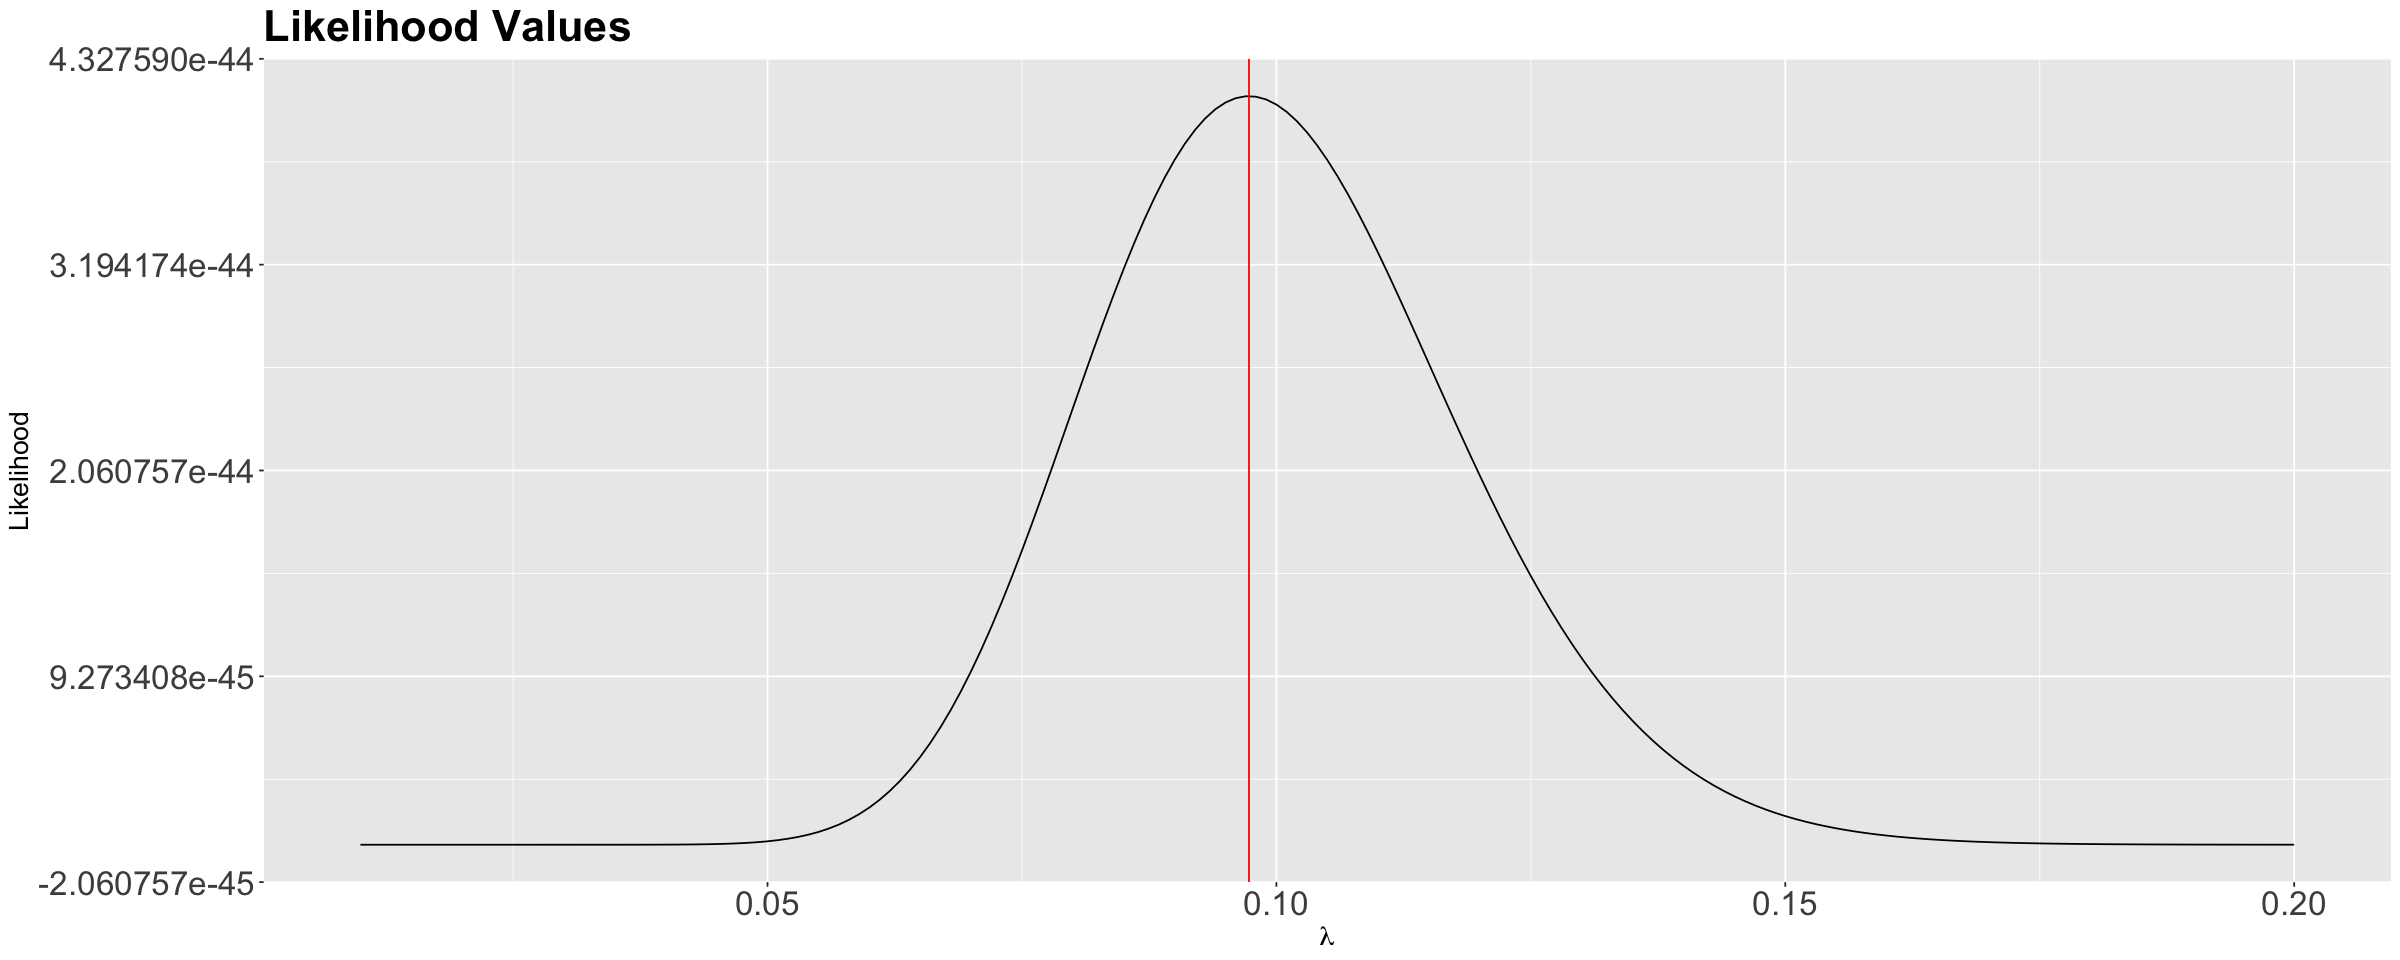

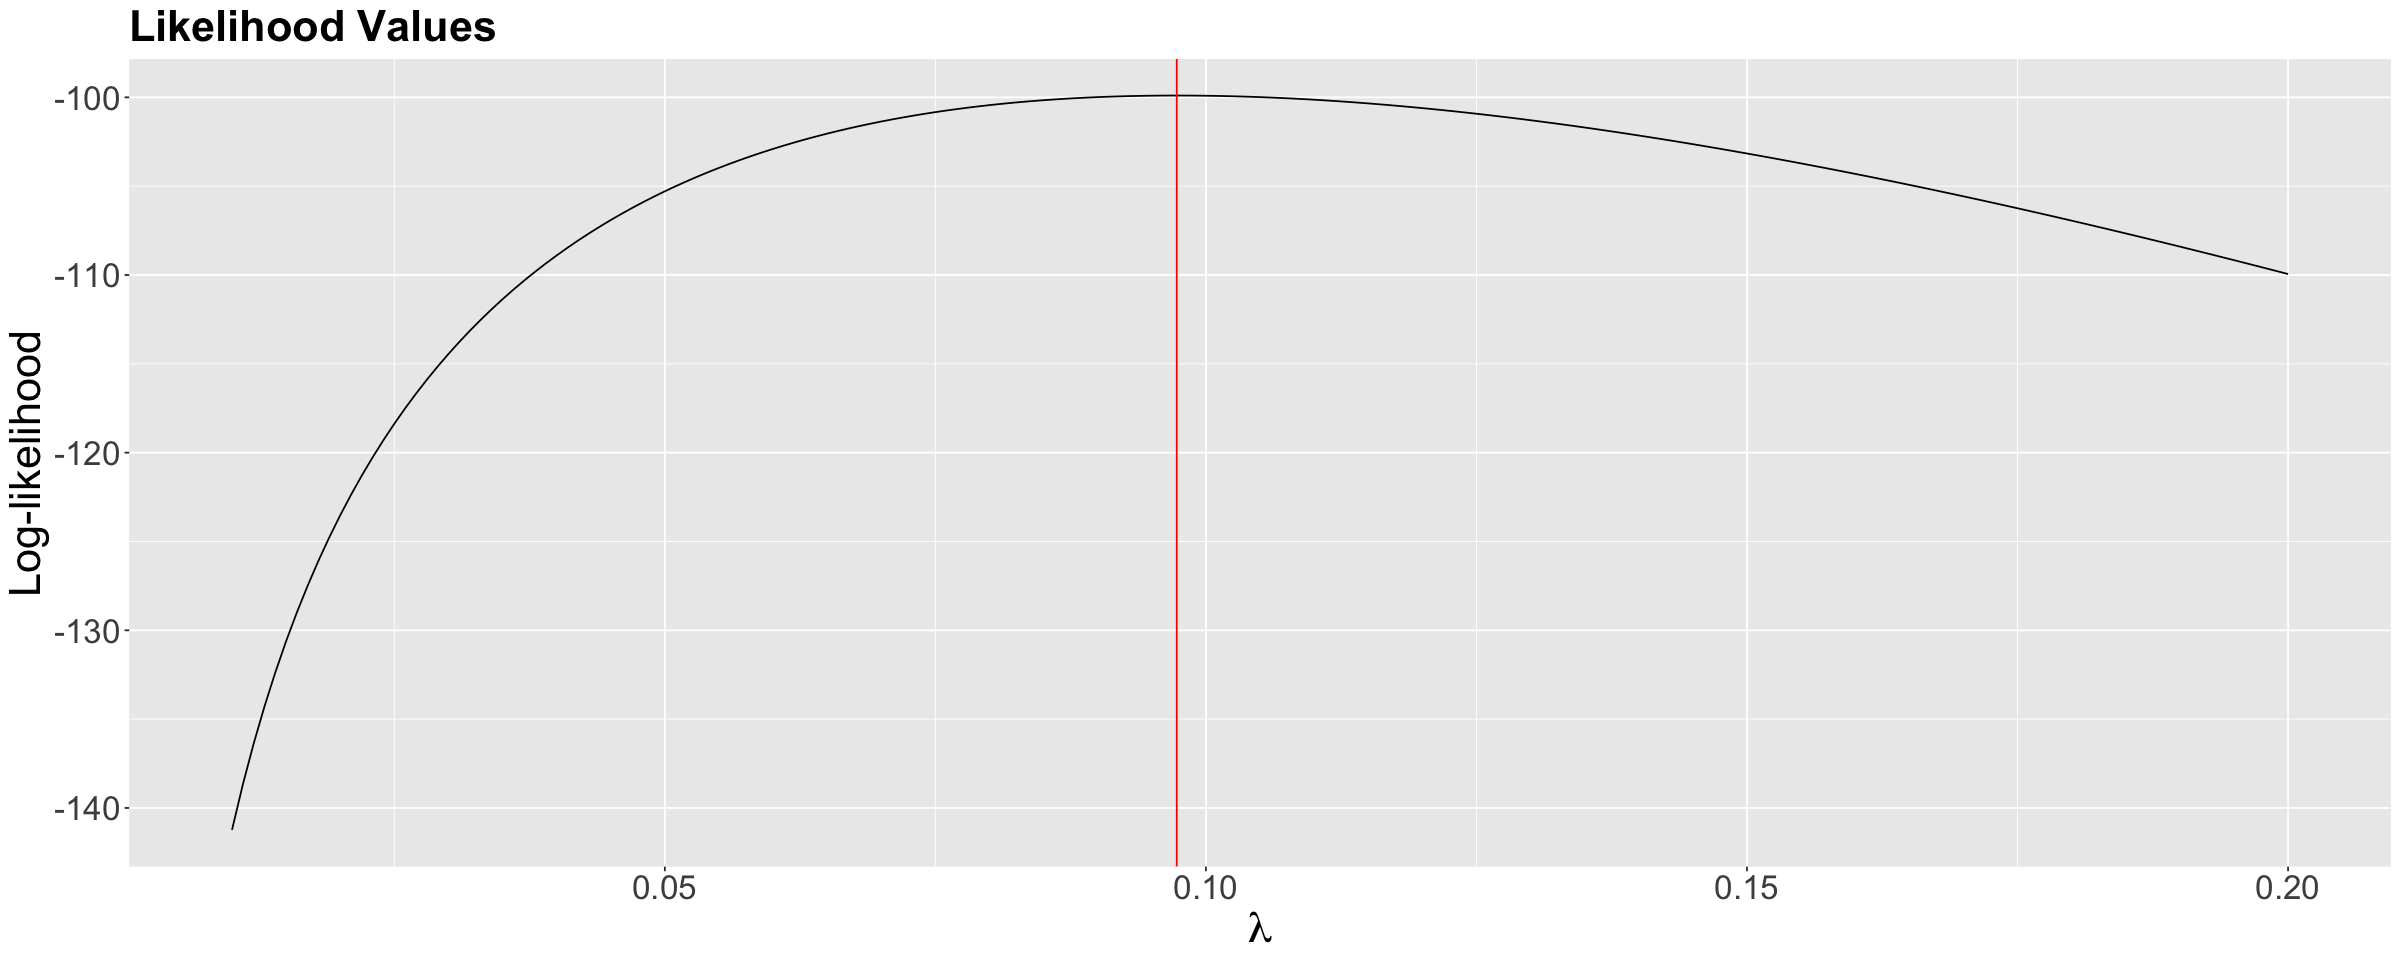

In [22]:
exp_like_plot +
  geom_vline(xintercept = analytical_MLE, colour = "red")

exp_log_like_plot +
  geom_vline(xintercept = analytical_MLE, colour = "red")

**What if we compare this analytical result versus the empirical one?**

In [23]:
empirical_MLE

possible_lambdas,likelihood,log_likelihood
<dbl>,<dbl>,<dbl>
0.097,4.121515e-44,-99.89752


In [24]:
round(analytical_MLE, 4)

[1] 0.0973

**Bam! It is the maximum!**

## 4. Probability versus Likelihood in Continuous Random Variables

Let us suppose we have a Standard Normal random variable $X$, i.e.,

$$
X \sim \mathcal{N}(\mu = 0, \sigma^2 = 1).
$$

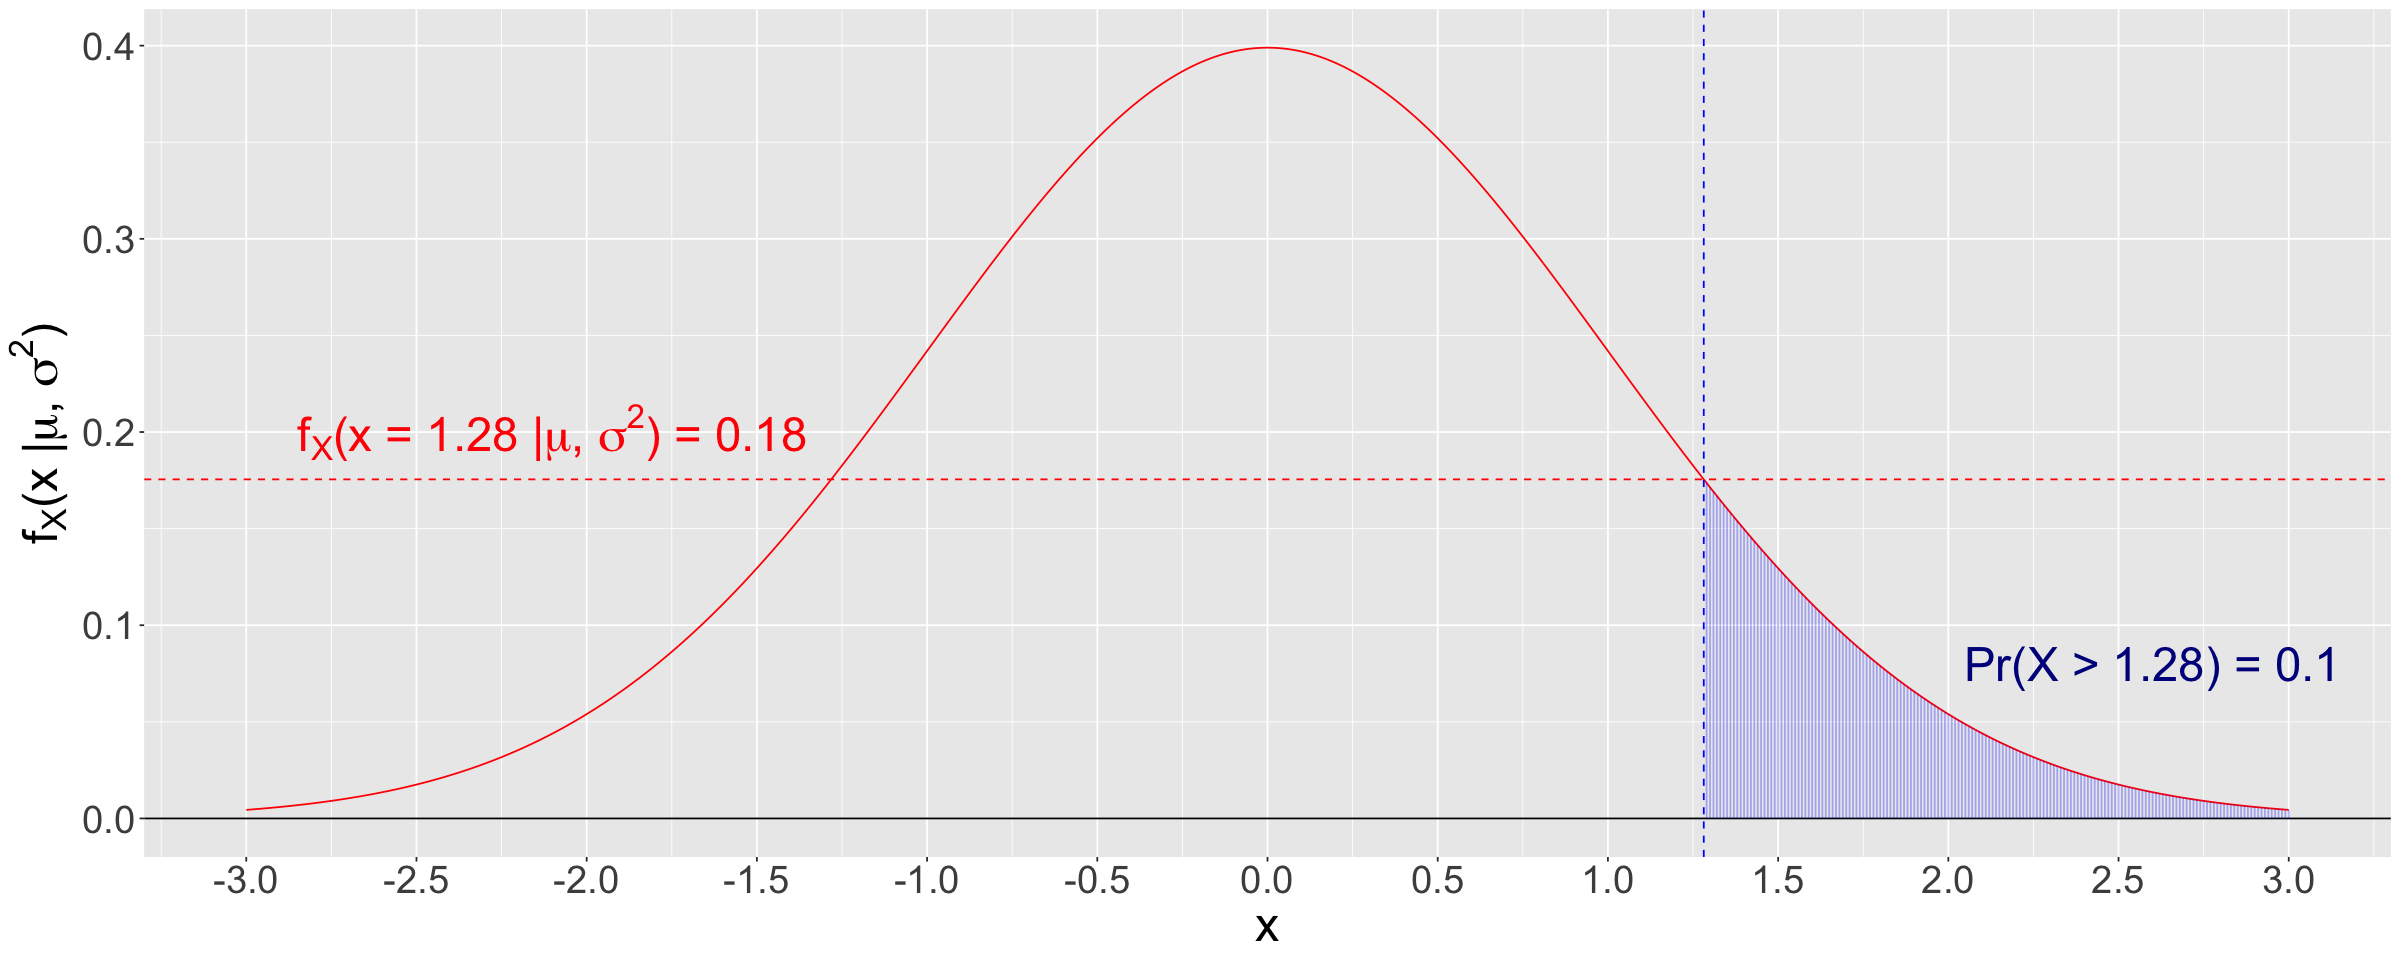

In [25]:
suppressWarnings(suppressMessages(print(prob_vs_likelihood())))

The plot shows $f_X(x \mid \mu, \sigma^2)$ on the vertical axis versus the corresponding quantiles
on the horizontal axis. We could establish the difference between **probability** and **likelihood**, in a continuous random variable, as follows:

- A **probability** is indicated as in the shaded blue area, e.g., $P(X > 1.28) = 0.1$. This is the area under the density curve.
- A **likelihood** is indicated in the horizontal dashed red line, e.g., $f_X(x = 1.28 \mid \mu, \sigma^2) = 0.18$. It is the PDF value on the $y$-axis for a given fixed observed $x$.

## 5. Wrapping up! 

MLE allows us to make inference on population parameters via the observed values of a random sample. This is a classical theory-based method where one needs to make strong distributional assumptions on the data. Moreover, the respective estimators are usually well-behaved (asymptotically speaking). We can even obtain confidence intervals for them.

It is essential to explore the foundations of this estimation approach since we use it in fields like regression or survival analysis. For instance, generalized linear models (GLMs) or parametric survival regression.

If we want to estimate assuming a distribution that has more than one parameter (e.g., $F$-distribution), things get a bit more complicated:

- Mathematically, solving this matter involves complex partial derivatives **without closed solution**.
- Numerical optimization in `R` is possible using the `optim()` function.

Finally, we need to stress that we saw two MLE paths: the **empirical** and **analytical**.

### 5.1. Steps for Empirical MLE

**Step 1: Choose the right distribution for the $i$th ($i = 1 , \dots, n$) PDF or PMF**

- Using information you know about your sample of size $n$, choose a family of distributions.
- Identify the corresponding PDF (for continuous data) or PMF (for discrete data).

**Step 2: Obtain the joint or PDF or PMF**

Once we have the $i$th PDF or PMF, build the joint function.

**Step 3: Obtain the joint likelihood function**

Recall this function is mathematically equivalent to the joint PDF or PMF.

**Step 4:  Obtain the joint log-likelihood function**

Use the rules of logarithms on the joint likelihood function.

**Step 5: Vary the parameters for that family of distribution and calculate the likelihood or log-likelihood**

- Use information about the data to help choose the range of values to vary the parameter over.
- Given your observed sample and the likelihood or log-likelihood functions, vary the parameter's value all over that range and compute their corresponding values.

**Step 6: Choose the parameter value that gives you the maximum likelihood or log-likelihood**

This value will be the maximum likelihood estimate under which your observed data is most likely.

### 5.2. Steps for Analytical MLE

**Steps 1, 2, 3, and 4 are the same.**

**Step 5: Obtain the partial derivative with respect to the parameter of interest**

You have to use the log-likelihood function since its form makes derivation easier.

**Step 6: Set the partial derivative equal to zero and solve for the parameter of interest**

We are doing this because it is an optimization problem.

```{caution}
In cases of no analytical solution in this step, we need a numerical optimization method.
```

**Step 7: Check you have a maximum**

You can do it using the second partial derivative criterion with respect to the same parameter of interest.

## 6. Supplementary Material

### The use of the `optim()` function

Let us use `R`'s `optimize()`, to obtain $\hat{\lambda}$ with `sample_n30`. This function uses numerical optimization and finds the point where the slope is `0` (maximum). 

`optimize()` needs at least these 3 things:
- The log-likelihood function (that references your data)
- A range of values to vary the parameter over (here `0.01` to `0.2`).
- Whether to return the minimum or the maximum of the function.

In [26]:
LL <- function(l) log(prod(dexp(sample_n30$values, l)))
optimize(LL, c(0.01, 0.2), maximum = TRUE)

$maximum
[1] 0.09728478

$objective
[1] -99.89738

## 7. Questions you might have...

1. Previously, when we estimated things like mean, standard deviation, or proportion of successes, we only calculated these values from the sample using a simple formula. So why are we using more complicated math now to arrive at essentially the same thing?

> MLE provides you with a great way to **FIND** estimators, which are usually well-behaved (asymptotically speaking!). Finding good estimators is a difficult task. The sample mean is a trivial case with a very intuitive answer. However, sometimes you are trying to estimate something much more complex. For example $\beta_0$ and $\beta_1$ from a linear regression model: $Y = \beta_0 + \beta_1 X_1 + \varepsilon$. How would you estimate these parameters when $\varepsilon \sim \mathcal{N}(0, \sigma^2)$? MLE can help with that! It is an alternative to least squares estimation (to be seen in **DSCI 561**).  In more complex regression frameworks, such as generalized linear models (GLMs), MLE is the parameter estimation method.

2. OK, we are using a different estimation technique - what about that plausible range for an estimate? For example, if I use MLE to estimate a mean and a standard deviation, how do I calculate a plausible range (i.e., confidence intervals for this estimate)?

> We can come up with the sampling distribution like we do for any given estimator: through asymptotics or bootstrap.

3. When we talked about estimation in general, we said you could estimate any "thing/object." Primarily we have been working with point estimates, but it could be a function (e.g., empirical distribution function or empirical cumulative distribution function) or other things (a classifier, for example). Are we "limited" to estimating distributions and/or distributional parameters of probability distributions when using MLE?

> The MLE is "limited" to estimating *parameters*, specifically. But we can then use those estimates to compute other things (and one can prove that those computations are also the MLE, if we were to reparameterize in terms of that quantity). Same with a classifier - first get the MLE of a parameter (like in logistic regression), then do classification. You will see this in the upcoming Machine Learning courses.